<a href="https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YoloV3 TF2 GPU Colab Notebook

##### 1.  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [1]:
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Found existing installation: keras 2.6.0
Uninstalling keras-2.6.0:
  Successfully uninstalled keras-2.6.0


In [2]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt
!pip install keras==2.4.2

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 425, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 425 (delta 5), reused 1 (delta 0), pack-reused 412
Receiving objects: 100% (425/425), 4.24 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (242/242), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 394.5 MB 31 kB/s 
     |████████████████████████████████| 28.7 MB 52 kB/s 
     |████████████████████████████████| 2.9 MB 40.7 MB/s 
     |████████████████████████████████| 3.8 MB 40.6 MB/s 
     |████████████████████████████████| 462 kB 41.5 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.0
    Uninstalling grpcio-1.41.0:
      Successfully uninstalled grpcio-1.41.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling ten

##### 2.  Check Tensorflow2 version

In [1]:
%cd yolov3-tf2/
!ls

import tensorflow as tf
tf.__version__

/content/yolov3-tf2
checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


'2.4.2'

##### 3.  Convert Pretrained Darknet Weight

In [4]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py --weights ./data/yolov3.weights --output /checkpoints/yolov3.tf

--2021-10-09 13:31:33--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  62.4MB/s    in 4.0s    

2021-10-09 13:31:37 (58.5 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2021-10-09 13:31:38.024389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-09 13:31:39.996581: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 13:31:39.999449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-09 13:31:40.025914: I tensorflow/stream_executor/cuda/cuda_gpu_exec

##### 4. Initialize Detector

In [5]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import YoloV3, YoloV3Tiny
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [7]:
!ls -l checkpoints

total 242288
-rw-r--r-- 1 root root        75 Oct  9 13:29 checkpoint
-rw-r--r-- 1 root root 248070167 Oct  9 13:29 yolov3.tf.data-00000-of-00001
-rw-r--r-- 1 root root     24143 Oct  9 13:29 yolov3.tf.index


In [8]:
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### 4. Detect Image

In [9]:
yolo = YoloV3(classes=FLAGS.num_classes)
yolo.load_weights(FLAGS.weights).expect_partial()
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [10]:
def detector():
    img_raw = tf.image.decode_image(open(FLAGS.image,'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    print(f'time: {t2 - t1}')

    for i in range(nums[0]):
        print(f'detections: {class_names[int(classes[0][i])]}, {np.array(scores[0][i])}, {np.array(boxes[0][i])}')

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

    return img

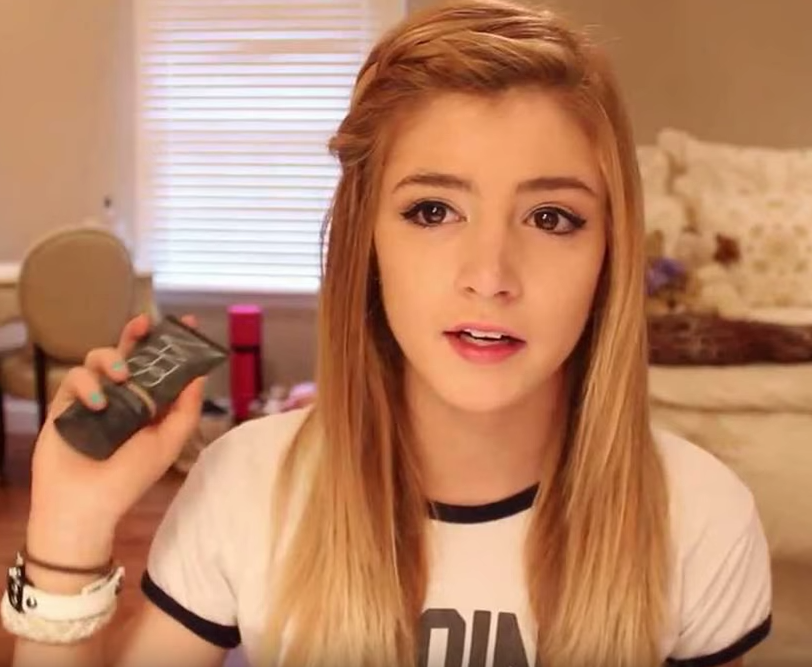

In [11]:
FLAGS.image = 'data/girl.png'
Image(filename=FLAGS.image, width=500)

time: 0.13433361053466797
detections: person, 0.9997697472572327, [0.06754467 0.03718731 0.967988   0.965075  ]
detections: chair, 0.9255481958389282, [0.01851869 0.34200275 0.17385137 0.62783295]


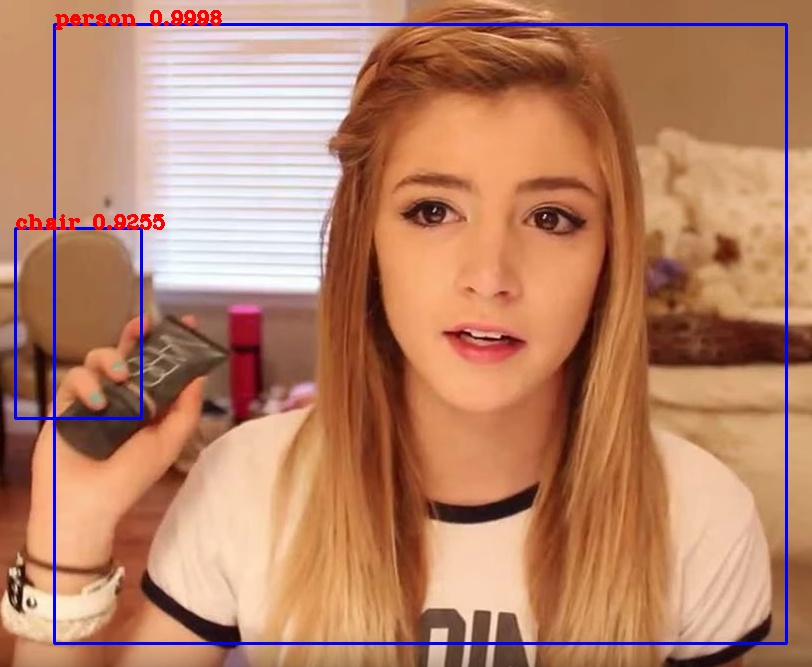

In [13]:
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=500))

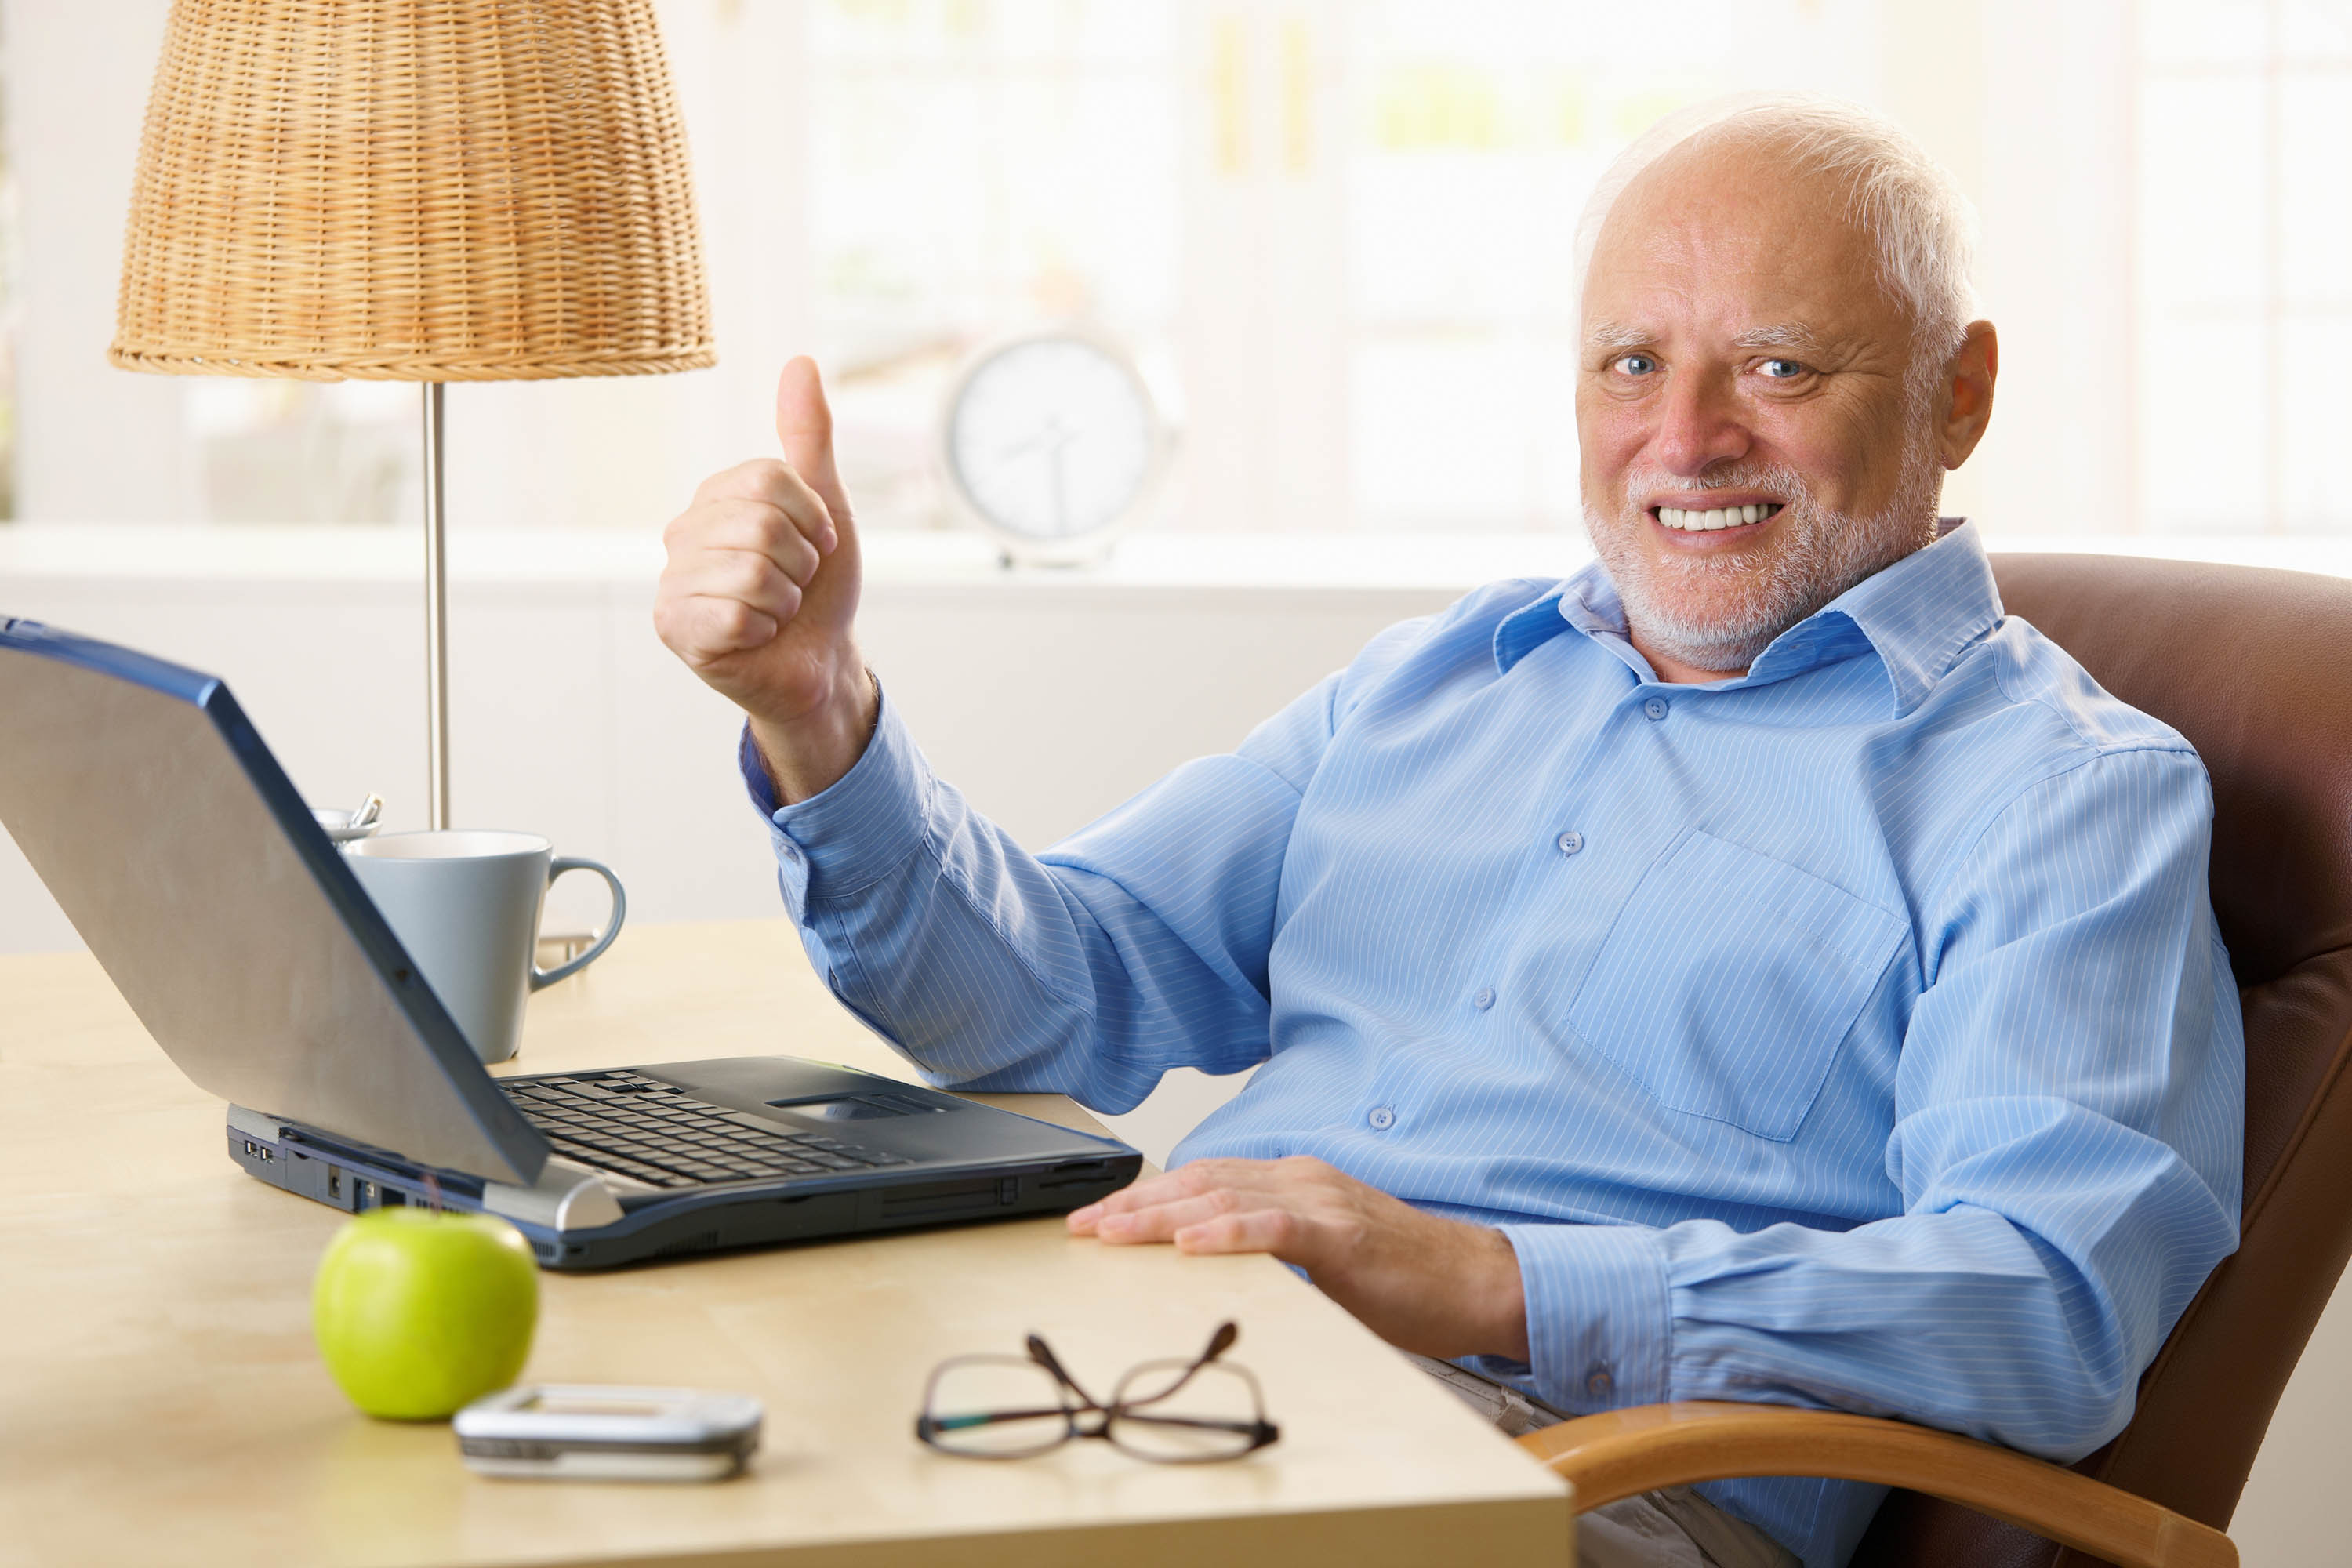

In [16]:
FLAGS.image = 'data/meme.jpg'
Image(filename=FLAGS.image, width=800)

time: 0.13431024551391602
detections: cup, 0.9980731010437012, [0.14266217 0.52777606 0.27184254 0.65748256]
detections: person, 0.9976975321769714, [0.28982913 0.09854645 0.95846486 0.9202166 ]
detections: laptop, 0.9599871039390564, [-0.01710659  0.39493686  0.52297276  0.7962776 ]
detections: apple, 0.9081621170043945, [0.13114464 0.77143586 0.22893354 0.90729535]
detections: cell phone, 0.7321372628211975, [0.18850097 0.87569416 0.3350185  0.9422209 ]
detections: clock, 0.6700015068054199, [0.4010809  0.21244614 0.49267417 0.35021502]


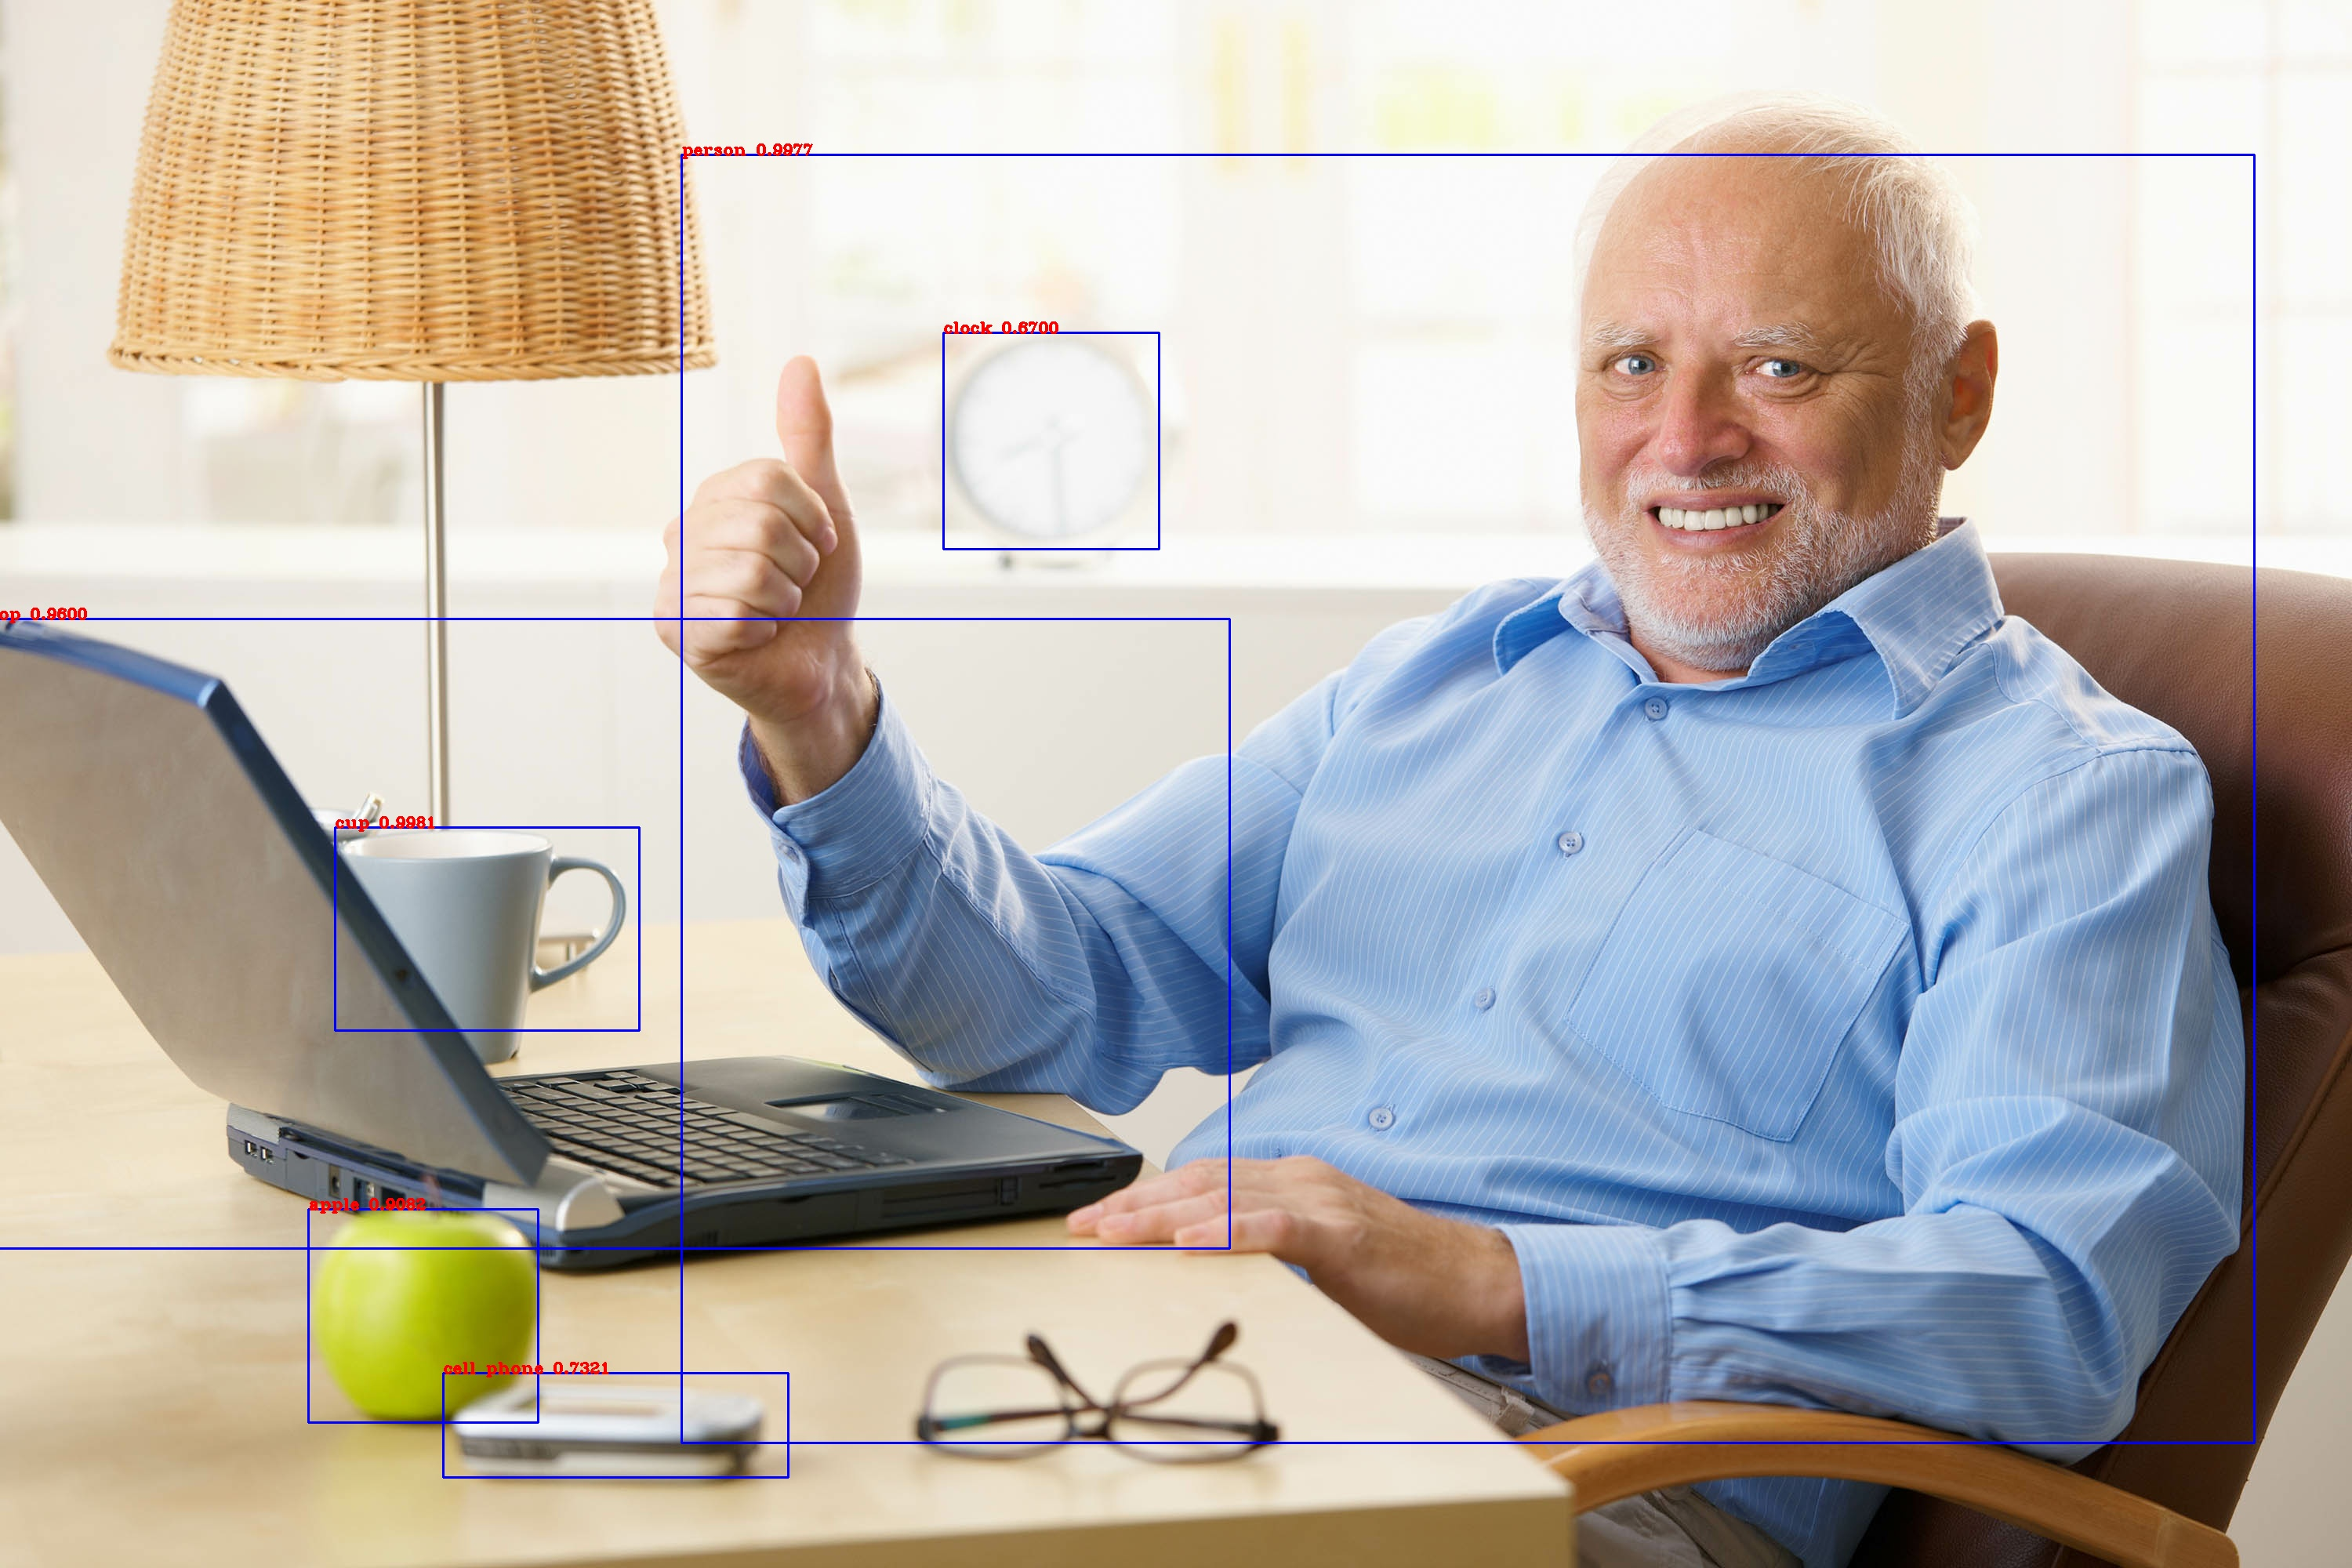

In [17]:
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=800))

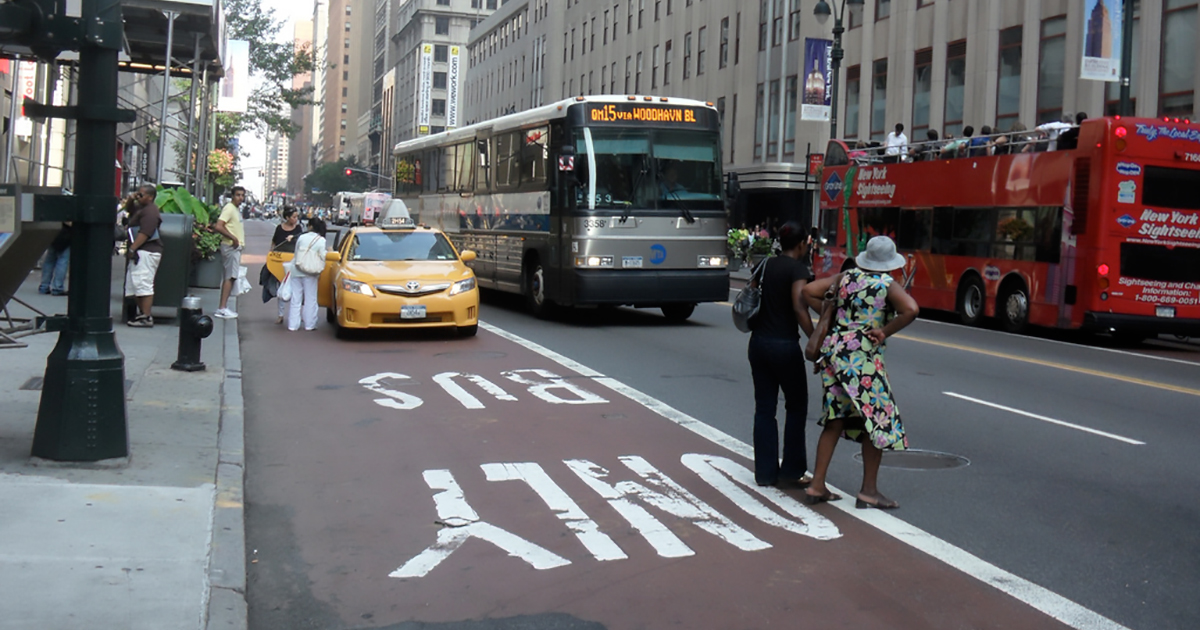

In [18]:
FLAGS.image = 'data/street.jpg'
Image(filename=FLAGS.image, width=1000)

time: 0.1334850788116455
detections: car, 0.9966800212860107, [0.26270664 0.3466965  0.40587908 0.54019135]
detections: bus, 0.9951198101043701, [0.6701458  0.17855006 0.99371713 0.5290145 ]
detections: person, 0.987026572227478, [0.6138846  0.34505433 0.6877058  0.77529997]
detections: bus, 0.9826598763465881, [0.3228875  0.15145972 0.6138201  0.50668204]
detections: person, 0.9748106002807617, [0.22922695 0.34322935 0.26619267 0.52385163]
detections: person, 0.9731234908103943, [0.10603388 0.29673997 0.14109921 0.5205003 ]
detections: person, 0.9698238372802734, [0.6745359  0.36693066 0.76731586 0.80656105]
detections: person, 0.8404207229614258, [0.73152274 0.19712627 0.76029474 0.2559415 ]
detections: person, 0.7661870718002319, [0.14938346 0.30133063 0.20066255 0.57802963]
detections: person, 0.6201282739639282, [0.8069899  0.19955893 0.82683456 0.24689196]
detections: traffic light, 0.5584413409233093, [0.2863981  0.26624355 0.29791862 0.28726056]


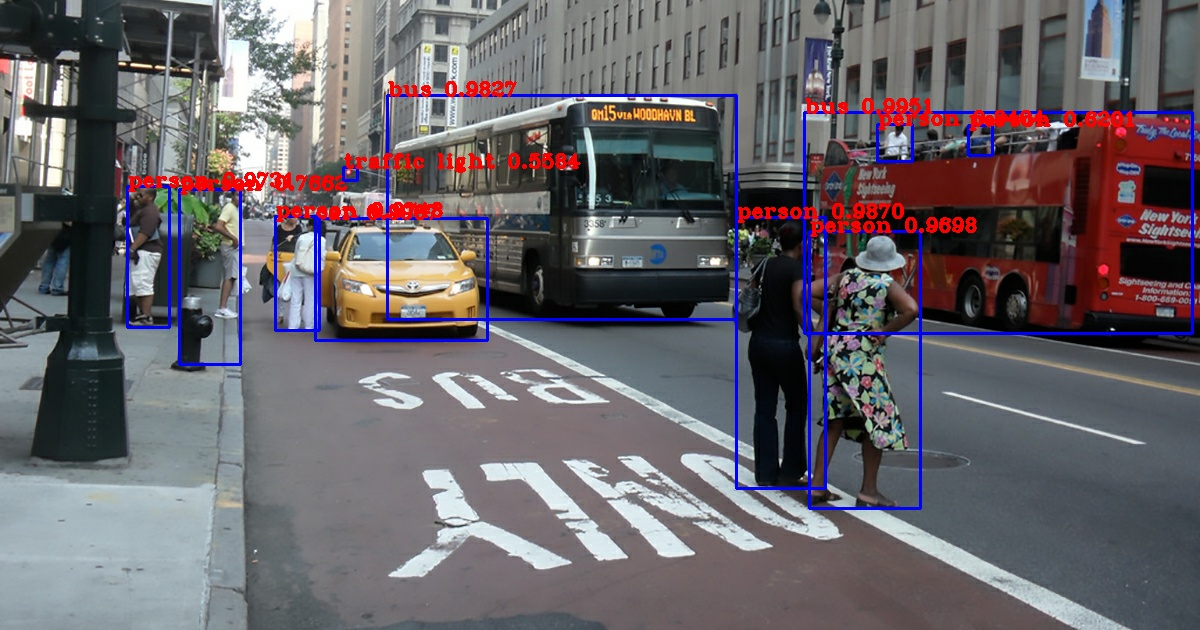

In [19]:
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=1000))

time: 0.1329333782196045
detections: person, 0.9996726512908936, [0.10497871 0.17179069 0.47821978 0.9957652 ]
detections: person, 0.9945406913757324, [0.45602348 0.06149825 0.72744524 0.98329854]
detections: person, 0.9557744860649109, [0.70693105 0.22946644 0.9155969  1.020992  ]
detections: person, 0.9102912545204163, [0.93971944 0.434443   1.0022458  0.89688945]
detections: person, 0.6195993423461914, [0.08753045 0.41167548 0.1840096  0.7732612 ]


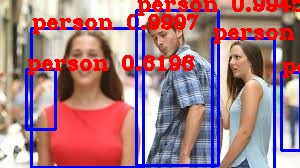

In [21]:
FLAGS.image = 'data/meme2.jpeg'
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=400))

## 여기까지 진행

##### 5. Training New Dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
!mkdir -p ./data/voc2009_raw
!tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw

--2020-02-02 07:42:05--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘./data/voc2009_raw.tar’

./data/voc2009_raw. 100%[===================>] 892.19M  12.8MB/s    in 70s     

2020-02-02 07:43:15 (12.8 MB/s) - ‘./data/voc2009_raw.tar’ saved [935534080/935534080]



In [ ]:
!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2020-02-02 07:43:26.544079: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:26.544194: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:26.544212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0202 07:43:27.628061 140379651344256 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 1

In [ ]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

2020-02-02 07:43:41.774830: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:41.774936: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:41.774955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0202 07:43:42.585982 139924403734400 visualize_dataset.py:22] classes loaded
2020-02-02 07:43:42.739779: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because t

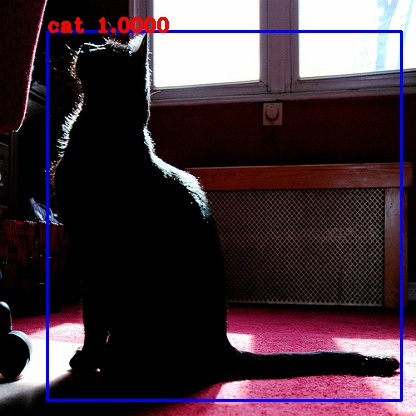

In [ ]:
from IPython.display import Image
Image(filename='./output.jpg')

In [ ]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2020-02-02 07:44:14.946313: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:44:14.946449: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:44:14.946465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Epoch 1/3
2020-02-02 07:44:51.124510: W tensorflow/core/common_runtime/bfc_allocator.cc:309] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to

##### 6. Detect using new weights

80
checkpoints/yolov3_train_3.tf
False


I0202 08:07:54.499751 139839832848256 <ipython-input-23-b2060d0f067f>:20] weights loaded
I0202 08:07:54.501296 139839832848256 <ipython-input-23-b2060d0f067f>:23] classes loaded
I0202 08:07:54.765269 139839832848256 <ipython-input-23-b2060d0f067f>:34] time: 0.22004270553588867
I0202 08:07:54.766204 139839832848256 <ipython-input-23-b2060d0f067f>:36] detections:
I0202 08:07:54.773281 139839832848256 <ipython-input-23-b2060d0f067f>:40] 	person, 0.20115408301353455, [0.2177423  0.2220931  0.95681787 0.77683055]


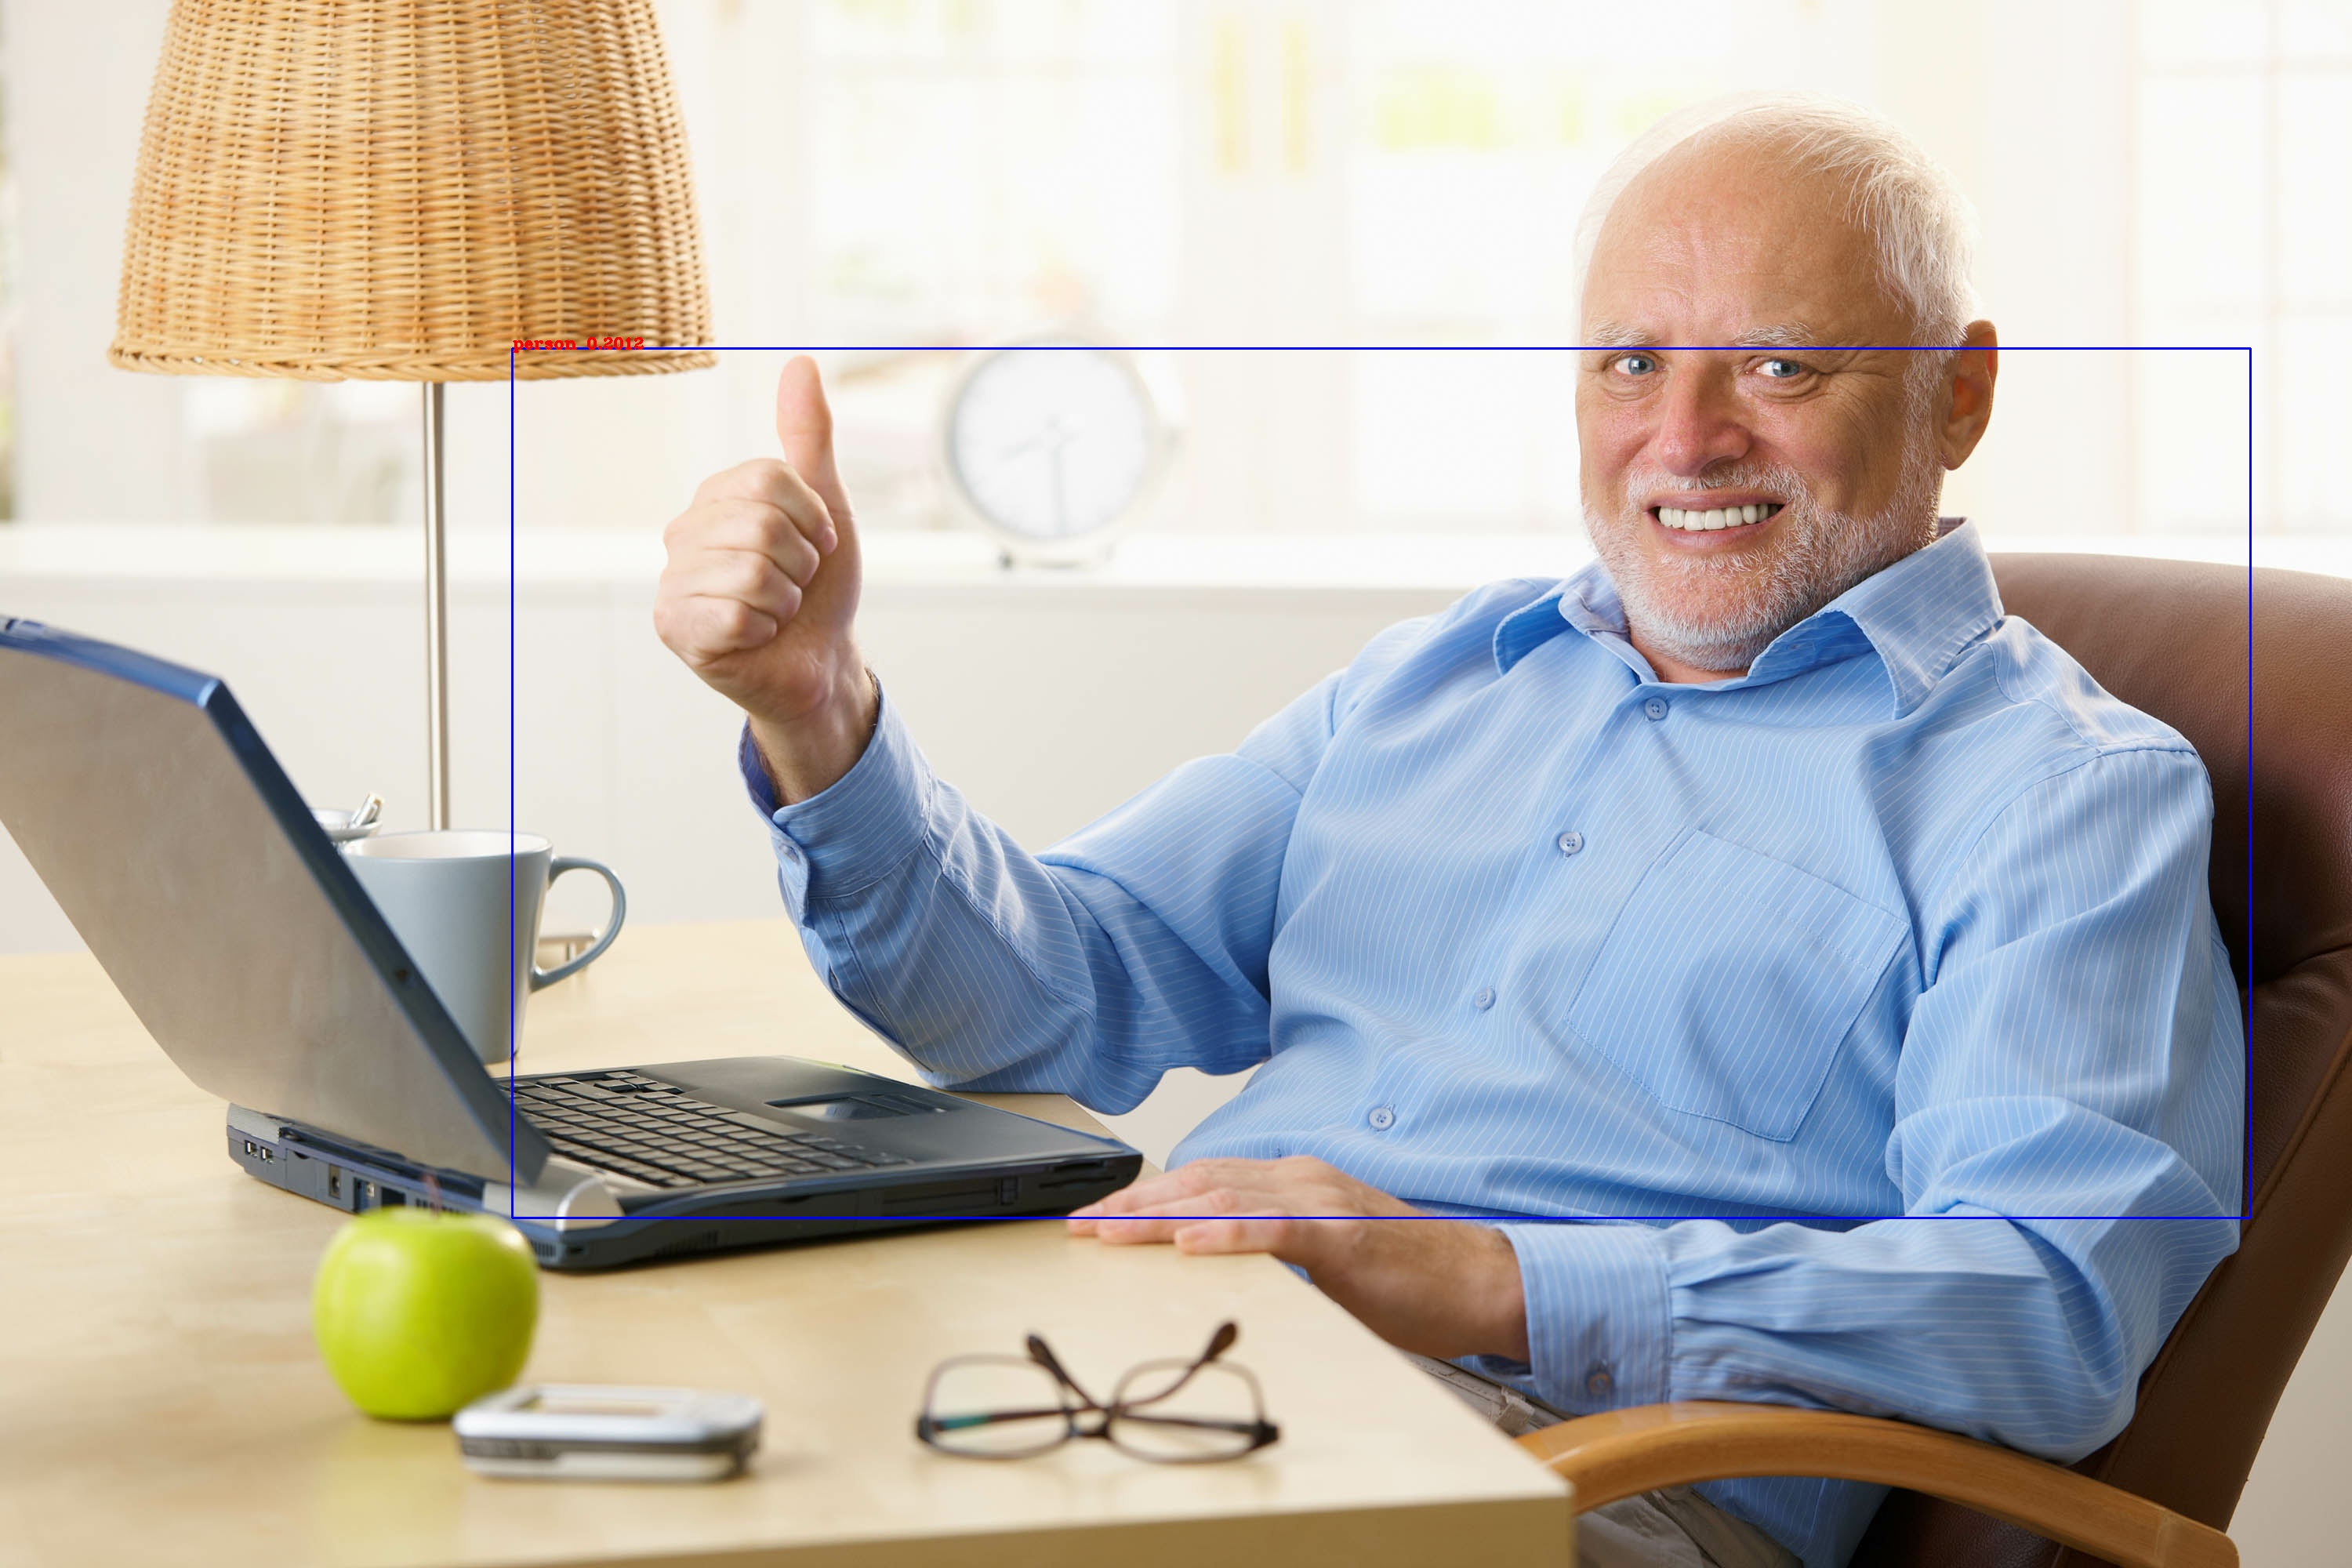

In [ ]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
FLAGS.image = 'data/meme.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))